# 数据预处理

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
import psutil
import os

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.style.use('fivethirtyeight') 

In [2]:
#读取全部数据
df = pd.read_table('../GIS_LSH_VE_CF/data/Gowalla_totalCheckins.txt',sep="\t",names=['user_id','check-in time','latitude','longitude','location id'],encoding='latin-1',engine='python')
df.shape

(6442892, 5)

In [17]:
def distribution_scatter(df):
    '''
        传入df数据结构，绘制经纬度散点图
    '''
    plt.figure(1 , figsize = (15 , 6))
    plt.scatter(x = 'latitude' , y = 'longitude' , data = df ,
                    s = 80 , alpha = 0.5 )
    plt.xlabel('latitude' ), plt.ylabel('longitude') 
    plt.title('Latitude and longitude distribution')
    plt.show()


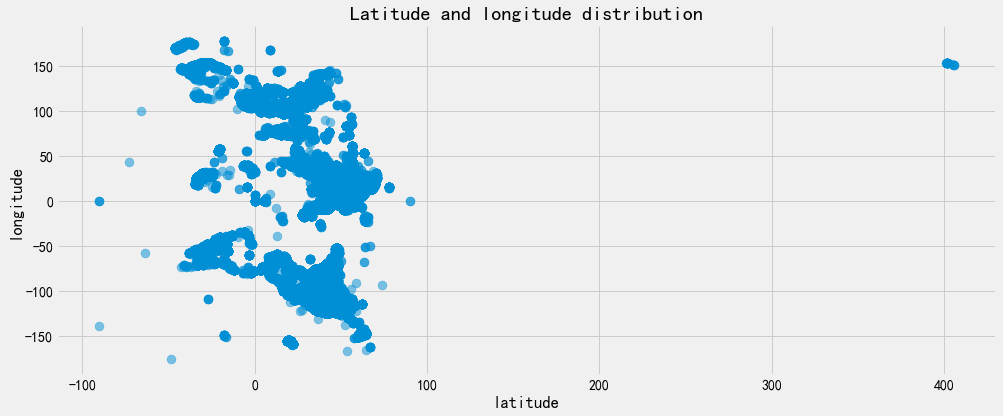

In [4]:
distribution_scatter(df)

In [48]:
# 查看用户和打卡地点
user_num = df['user_id'].unique().shape[0]
loc_num = df['location id'].unique().shape[0]
print("数据规模为:{0}条,用户有:{1}个,打卡地点有:{2}个".format(df.shape[0],user_num,loc_num))

数据规模为:6442892条,用户有:107092个,打卡地点有:1280969个


## 进行数据抽取，注意：所有数据集都要把第一行手动删除

In [ ]:
# 一个用户抽取两条信息，抽取12000条数据,共计6000个用户
user_id_list = df['user_id'].unique()
data = df.iloc[:12000]
for i in range(12000):
    user_id = user_id_list[int(i/2)] # 每个用户取两条信息
    print(user_id)
    data.iloc[i] = df[df['user_id']==user_id].iloc[i%2] # 根据取余运算，取第0行和第1行
data.head()

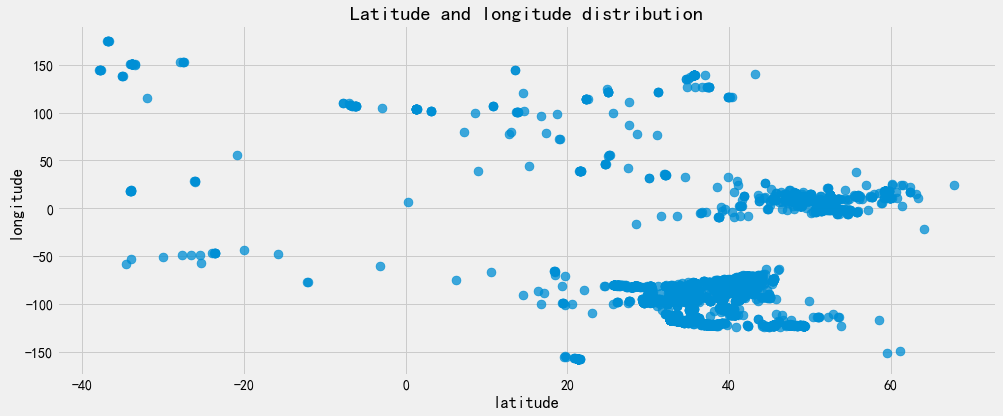

In [51]:
distribution_scatter(data)

In [14]:
# 将user_id作为索引，删除没用的信息
data.index = data['user_id']
del data['check-in time']
del data['user_id']
del data['location_id']
data.to_csv('../GIS_LSH_VE_CF/data/data.csv')
data.head()

,latitude,longitude
0,30.235909,-97.795140
0,30.269103,-97.749395
1,48.863379,2.333329
1,48.863379,2.333329
2,34.043023,-118.267157


## 随机选取1000个用户作为测试集，剩下的作为训练集

In [21]:
import random
index = set(data.index)
test_id = random.sample(index,1000)
test_data = data.loc[test_id]
test_data.to_csv('../GIS_LSH_VE_CF/data/test.csv')

train_id = index-set(test_id)
train_data = data.loc[train_id]
train_data.to_csv('../GIS_LSH_VE_CF/data/train.csv')

C:\Users\zwt\AppData\Local\Temp\ipykernel_6772\1658871224.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_id = random.sample(index,1000)
C:\Users\zwt\AppData\Local\Temp\ipykernel_6772\1658871224.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_data = data.loc[train_id]


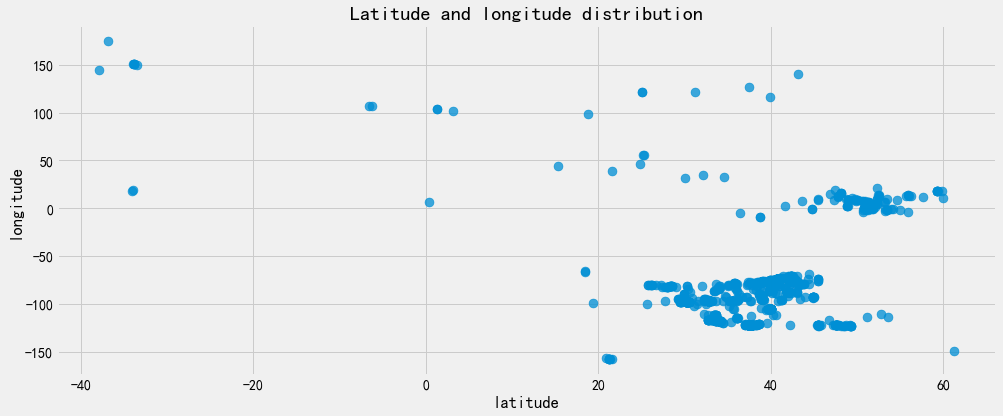

In [18]:
distribution_scatter(test_data)

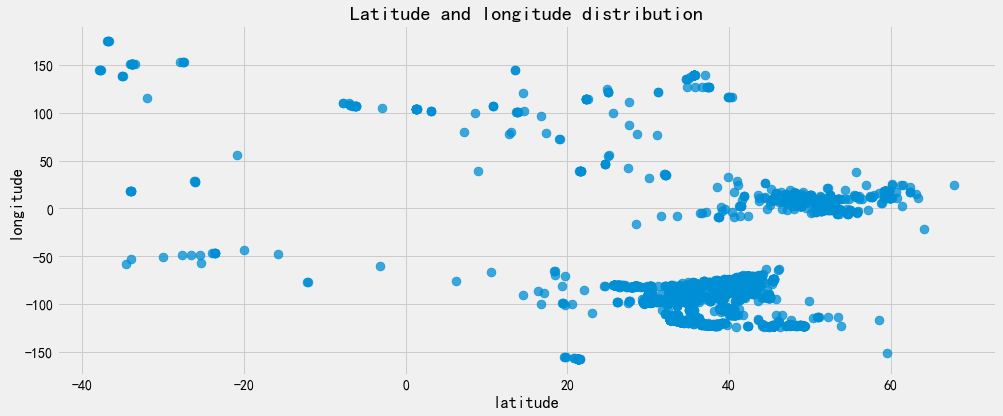

In [19]:
distribution_scatter(train_data)

## 构建用户坐标矩阵，便于之后训练

In [20]:
user_mx = data.groupby(data.index).sum()
user_mx.head()

,latitude,longitude
0,60.505012,-195.544535
1,97.726758,4.666657
2,68.086046,-236.534314
4,75.565209,-244.815216
7,60.538206,-195.498791


In [61]:
# 将用户的经纬度转换为list存储
data_latitude = data.groupby(data.index).latitude.apply(list)
data_longitude = data.groupby(data.index).longitude.apply(list)

In [66]:
# 将用户的经纬度化为数组存储，以用户为索引，便于之后的计算
user_mx['user_id'] = user_mx.index
def latitude(userId):
    return data_latitude[userId]

def longitude(userId):
    return data_longitude[userId]
user_mx['latitude'] = user_mx['user_id'].apply(latitude)
user_mx['longitude'] = user_mx['user_id'].apply(longitude)
del user_mx['location id']
del user_mx['user_id']
user_mx.head()

,latitude,longitude
user_id,,
0,"[30.2359091167, 30.2691029532]","[-97.7951395833, -97.7493953705]"
1,"[48.86337875, 48.86337875]","[2.333328717, 2.333328717]"
2,"[34.0430230998, 34.0430230998]","[-118.2671570778, -118.2671570778]"
4,"[37.7826046833, 37.7826046833]","[-122.4076080167, -122.4076080167]"
5,"[40.761176868, 40.761176868]","[-73.9868709323, -73.9868709323]"


In [28]:
user_mx.to_csv('../GIS_LSH_VE_CF/data/user_mx.csv')

# 生成恶意数据

In [6]:
import pandas as pd
import random
original_data = pd.read_table('../GIS_LSH_VE_CF/data/train.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')

In [7]:
round(random.uniform(0,90),3)

48.032

In [8]:
import random
train_data = original_data[0:5000]
attack_data = train_data
user_id, attack_la, attack_long = [], [], []
temp = 16000
for i in range(5000): # 用户索引和经纬度进行随机生成
    user_id.append(int(temp/2))
    attack_la.append(round(random.uniform(0,10000),3))
    attack_long.append(round(random.uniform(0,100000),3))
    temp = temp + 1
attack_data['id'] = user_id
attack_data['longitude'] = attack_long
attack_data['latitude'] = attack_la
attack_data = attack_data.set_index('id')
attack_data.to_csv("../GIS_LSH_VE_CF/data/attack_data.csv")

C:\Users\20F2\AppData\Local\Temp\ipykernel_4012\2737638264.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data['id'] = user_id
C:\Users\20F2\AppData\Local\Temp\ipykernel_4012\2737638264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data['longitude'] = attack_long
C:\Users\20F2\AppData\Local\Temp\ipykernel_4012\2737638264.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

# 用户攻击矩阵

In [9]:
import pandas as pd
attack_data = pd.read_table('../GIS_LSH_VE_CF/data/attack_data.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
attack_user_mx = attack_data.groupby(attack_data.index).sum()
attack_user_mx.head()

,latitude,longitude
10000,6694.6532767.031,99516.13519644.837
10001,565.8668691.151,89882.82359530.881
10002,8519.3731675.2,82948.02111825.305
10003,8058.17966.607,57582.4996748.947
10004,4579.095230.88,14740.15370109.421


In [10]:
# 将用户的经纬度转换为list存储
attack_data_latitude = attack_data.groupby(attack_data.index).latitude.apply(list)
attack_data_longitude = attack_data.groupby(attack_data.index).longitude.apply(list)

In [11]:
attack_user_mx['user_id'] = attack_user_mx.index
attack_user_mx

,latitude,longitude,user_id
10000,6694.6532767.031,99516.13519644.837,10000
10001,565.8668691.151,89882.82359530.881,10001
10002,8519.3731675.2,82948.02111825.305,10002
10003,8058.17966.607,57582.4996748.947,10003
10004,4579.095230.88,14740.15370109.421,10004
...,...,...,...
9996,2991.8523175.28,22924.3531281.812,9996
9997,6279.4154715.055,132.28428648.989,9997
9998,5159.0751951.587,57176.67533509.691,9998
9999,1528.0758455.134,7818.76417870.298,9999


In [12]:
# 将用户的经纬度化为数组存储，以用户为索引，便于之后的计算
attack_user_mx['user_id'] = attack_user_mx.index
def latitude(userId):
    return attack_data_latitude[userId]

def longitude(userId):
    return attack_data_longitude[userId]
attack_user_mx['latitude'] = attack_user_mx['user_id'].apply(latitude)
attack_user_mx['longitude'] = attack_user_mx['user_id'].apply(longitude)
del attack_user_mx['user_id']
attack_user_mx.head()

,latitude,longitude
10000,"[6694.653, 2767.031]","[99516.135, 19644.837]"
10001,"[565.866, 8691.151]","[89882.823, 59530.881]"
10002,"[8519.373, 1675.2]","[82948.021, 11825.305]"
10003,"[8058.17, 966.607]","[57582.499, 6748.947]"
10004,"[4579.095, 230.88]","[14740.153, 70109.421]"


In [23]:
attack_user_mx.to_csv("../GIS_LSH_VE_CF/data/attack_user_mx")